# Iceberg 2, Matt 0
> Reusing the random forest techniques for the Titanic on another dataset

- toc: false
- badges: true
- comments: true
- author: Matt Bowen
- categories: [jupyter, kaggle]

## Introduction

In a [previous post](https://bobowedge.github.io/adventures-in-telework/jupyter/2021/01/31/titanic-kaggle.html), I wrote about using some random forest techniques to tackle the [Kaggle Titanic Competition](https://www.kaggle.com/c/titanic).  Last week, I found out that there's a [monthly competition](https://www.kaggle.com/c/tabular-playground-series-apr-2021) that mimics the original Titanic competition, but uses synthetic data based on the original dataset instead. I thought it would be good to revisit the previous code I wrote and try it against this new dataset.

I'm not going to rehash everything I did before, but rather focus on the random forests, feature engineering, and neural networks to see what results I can get.

In [2]:
#collapse
# imports, imports, imports
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import zero_one_loss

# Pandas display options
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

## Setup

### Data

As before, the competition provides a training set (passenger data with a 'Survived' column) and a test set (passenger data without a 'Survived' column) and asks to be provided the prediced 'Survived' column for the test set.

In [2]:
# Dependent variable
dep_var = 'Survived'
# Training set
train_df = pd.read_csv("train.csv")
# Test set
test_df = pd.read_csv("test.csv")

As a reminder, here what the training data looks like:

In [3]:
#hide_input
train_df

,PassengerId,Survived,Pclass,Name,Sex,...,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,...,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,...,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,...,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,...,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,...,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,...,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,...,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,...,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,...,1,458654,30.92,NaN,S


(If you refer back to the previous dataset, you can see that's there more than 100 times as much training data the in the original problem.)

Next, split the columns into either continuous and categorical types:

In [4]:
##
# Split the columns into categorical and continuous
cont_cols, cat_cols = cont_cat_split(train_df, 1, dep_var=dep_var)
print(f"Continuous columns: {cont_cols}")
print(f"Categorical columns: {cat_cols}")

Continuous columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### Reproducibility

One of the things that I overlooked and later regretted when trying to document my results the last time around was never setting any of the random seed. That meant I could never reproduce the exact results in a future run. And, certainly, no one else who ever tried to run my code would get the same results. {% fn 1 %}

I'm not the first `fastai` user to have this issue and [some kind stranger](https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/27) provided a function for setting some of the necessary seeds:

In [5]:
##
# Set random_seed
def random_seed(seed_value, use_cuda=True):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

Unfortunately, this doesn't seem to set the seed for `RandomSplitter` or `RandomForestClassifier`, so I'll have to set those manually as well to get reproducible results.

In [6]:
##
# Answer to Life, the Universe, and Everything
ALUE = 42
random_seed(ALUE)

### Training and Validation Data

Next, set up the training and validation data from the provided training set via `TabularPandas`:

In [7]:
##
# Operations for columns
column_ops = [Categorify, FillMissing]
# Split the training data randomly
splits = RandomSplitter(seed=ALUE)(range_of(train_df))
# Setup TabularPandas
tab_panda = TabularPandas(train_df, column_ops ,cat_cols, cont_cols, y_names=dep_var, splits=splits)
# Aliases for training data
trainxs, trainy = tab_panda.train.xs, tab_panda.train.y
# Aliases for validation data
validxs, validy = tab_panda.valid.xs, tab_panda.valid.y
print(f"Training set size: {len(trainxs)}")
print(f"Validation set size: {len(validxs)}")
trainxs

Training set size: 80000
Validation set size: 20000


,Name,Sex,Ticket,Cabin,Embarked,...,Pclass,Age,SibSp,Parch,Fare
1509,2687,1,51792,0,3,...,3,67.0,1,0,29.680000
83391,73357,2,68733,2240,3,...,3,30.0,1,2,27.450001
62311,6430,1,4381,0,1,...,2,45.0,1,1,28.690001
57794,76737,2,32105,0,1,...,2,32.0,0,0,19.879999
73100,39937,1,56183,0,3,...,3,10.0,1,0,27.110001
...,...,...,...,...,...,...,...,...,...,...,...
29010,87006,1,0,0,3,...,3,27.0,0,0,9.910000
77199,34744,2,43849,0,3,...,3,26.0,0,0,6.630000
44288,42095,2,16114,14524,3,...,1,2.0,0,0,28.629999
94835,9105,1,17880,9712,1,...,1,60.0,1,1,290.769989


Also, convert the test data to `TabularPandas`:

In [17]:
# Convert test data to TabularPandas
test_tab = TabularPandas(test_df, [Categorify, FillMissing], cat_cols, cont_cols)

## Random Forest

This is enough to set up the function to create random forests. Since there's a lot more data, I choose to up the default for the minimum number of samples per leaf:

In [8]:
##
# Create Random Forest and fit it
def create_rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=10):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_features=max_features, 
                                  min_samples_leaf=min_samples_leaf, oob_score=True, random_state=ALUE).fit(xs, y)

In [9]:
##
# 40-tree model with validation and out-of-bag (oob) error
model = create_rf(trainxs, trainy)
error = zero_one_loss(model.predict(validxs), validy)
print(f"Model error: {error:.04}")
print(f"Model oob error: {1.0 - model.oob_score_:.04}")

Model error: 0.2251
Model oob error: 0.2216


Last time, I somewhat arbitrarily picked a series of `n_estimator` values to try to deduce what the best number of trees was. This time{% fn 2 %}, I'm going to use the `GridSearch` available in sklearn.

In [13]:
##
# Classifier settings to use for all forests
rfc = RandomForestClassifier(max_features='auto', oob_score=True, random_state=ALUE, n_jobs=-1)

# Parameter grid to search
param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              "n_estimators": [50, 100, 400, 700]}

# Set up the grid search parameters
gs = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)

# Execute the grid search
gs = gs.fit(trainxs, trainy)

print(f"Best model error: {1.0 - gs.best_score_:.04}")
print(f"Best model parameters: {gs.best_params_}")

Best model error: 0.2167
Best model parameters: {'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 400}


The grid search took about 10 minutes to run on the GPU server I was using and produce the "best" model

In [15]:
##
# Select the best estimator from the grid search
gsrf = gs.best_estimator_
error = zero_one_loss(gsrf.predict(validxs), validy)
print(f"Model error: {error:.04}")
print(f"Model oob error: {1.0 - gsrf.oob_score_:.04}")

Model error: 0.2232
Model oob error: 0.2154


I'll note here that the model errors are different in the last two steps because one is from the cross-validation of the training set and one is from the validation set.{% fn 3 %}

Next, I used that model to predict the survivors from the test data and submit the predictions to kaggle:

In [18]:
##
# Use the model to predict the survivors from the test set
survived = gsrf.predict(test_tab.xs)
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv(f"tps-Apr2021_gridsearch.csv", index=False)

`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_gridsearch.csv -m "RF Grid search"`

In [19]:
# hide_input
print("RF Grid Search score: 0.79187")

RF Grid Search score: 0.79187


Just for fun, I also submitted the results of a model with 3000 trees to see whether that would be any better

In [20]:
model3000 = create_rf(trainxs, trainy, n_estimators=3000)
survived = model3000.predict(test_tab.xs)
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv(f"tps-Apr2021_rf-3000.csv", index=False)

`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_rf-3000.csv -m "RF with 3000 trees"`

In [21]:
# hide_input
print("RF 3000 score: 0.78166")

RF 3000 score: 0.78166


NB: The grid search does slightly better than just taking a larger tree. (With the larger data set, small percentage differences are more significant.)

## Feature Engineering

The next step was to improve the random forest models above by extracting, modifying, or deleting some of the given columns to create new, hopefully more relevant ones by [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). 

The collapse below has the features edits that I used last time, which I ~~stole~~ adapted from [this post](https://www.kaggle.com/zlatankr/titanic-random-forest-82-78).

In [22]:
#collapse
# Same edit_features as last time
def edit_features(df):
    mod_df = df.copy()
    
    # PassengerId - not meaningful for learning
    del mod_df["PassengerId"]
    
    # Pclass - treat passenger class as category
    mod_df["Pclass"] = mod_df["Pclass"].astype("category")
    
    # Name - Split into name length and title
    mod_df['NameLength'] = mod_df["Name"].apply(lambda x: len(x))
    mod_df['NameTitle'] = mod_df["Name"].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
    mod_df['NameTitle'] = mod_df["NameTitle"].astype("category")
    del mod_df["Name"]
    
    # Age - fill Age with mean grouped by title and class
    age_data = mod_df.groupby(['NameTitle', 'Pclass'])['Age']
    mod_df['Age_na'] = mod_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
    mod_df['Age_na'] = mod_df['Age_na'].astype("category")
    mod_df['Age'] = age_data.transform(lambda x: x.fillna(x.mean()))
    
    # SibSp + Parch => Family size category
    passengers = mod_df["SibSp"] + mod_df["Parch"] 
    mod_df['FamilySize'] = np.where(passengers == 0, 'Solo', np.where(passengers <= 3, 'Nuclear', 'Big'))
    mod_df["FamilySize"] = mod_df["FamilySize"].astype("category")
    del mod_df['SibSp']
    del mod_df['Parch']
    
    # Ticket - Split into two categories, 
    #  one based on the first letter of the ticket and 
    #  one based on the length
    mod_df["TicketLetter"] = mod_df["Ticket"].apply(lambda x: str(x)[0])
    mod_df["TicketLetter"] = mod_df["TicketLetter"].apply(lambda x: str(x))
    highTicket = mod_df['TicketLetter'].isin(['1', '2', '3', 'S', 'P', 'C', 'A'])
    lowTicket = mod_df['TicketLetter'].isin(['W', '4', '7', '6', 'L', '5', '8'])
    mod_df['TicketLetter'] = np.where(highTicket, mod_df["TicketLetter"],
                                      np.where(lowTicket, "LowTicket", "OtherTicket"))
    mod_df['TicketLength'] = mod_df['Ticket'].apply(lambda x: len(str(x)))
    del mod_df['Ticket']
    
    # Cabin - Split into the prefix and bin the number
    mod_df["CabinPrefix"] = mod_df['Cabin'].apply(lambda x: str(x)[0])
    mod_df["CabinPrefix"] = mod_df["CabinPrefix"].astype("category")
    del mod_df["Cabin"]
        
    # Embarked - Fill missing data with most common value ('S')
    mod_df['Embarked'] = mod_df['Embarked'].fillna('S')
    
    return mod_df

### Data

The next step is to create the new dataframes for the validation and training set based on the feature edits.

In [24]:
##
# New data frame with modified features
fe_train_df = edit_features(train_df)

# Identify categorical and continuous columns and prep training data
fe_cont, fe_cat = cont_cat_split(fe_train_df, 1, dep_var=dep_var)
fe_splits = RandomSplitter(seed=ALUE)(range_of(fe_train_df))
fe_train_panda = TabularPandas(fe_train_df, column_ops, fe_cat, fe_cont, y_names=dep_var, splits=fe_splits)

# Alias training and validation data
fetrainxs, fetrainy = fe_train_panda.train.xs, fe_train_panda.train.y
fevalidxs, fevalidy = fe_train_panda.valid.xs, fe_train_panda.valid.y

fe_train_panda.show(3)

,Pclass,Sex,Embarked,NameTitle,Age_na,FamilySize,TicketLetter,CabinPrefix,Fare_na,Age,Fare,NameLength,TicketLength,Survived
1509,3,female,S,Patricia,False,Nuclear,OtherTicket,n,False,67.0,29.680000,16,4,0
83391,3,male,S,Robert,False,Nuclear,S,A,False,30.0,27.450001,14,12,0
62311,2,female,C,Karen,False,Nuclear,1,n,False,45.0,28.690001,16,6,0


In [25]:
##
# New data frame with modified features
fe_test_df = edit_features(test_df)

# Convert test data to TabularPandas
fe_test_panda = TabularPandas(fe_test_df, [Categorify, FillMissing], fe_cat, fe_cont)

fe_test_panda.show(3)

,Pclass,Sex,Embarked,NameTitle,Age_na,FamilySize,TicketLetter,CabinPrefix,Fare_na,Age,Fare,NameLength,TicketLength
0,3,male,S,Daniel,False,Solo,2,n,False,19.0,63.009998,16,5
1,3,female,S,Lorraine,False,Solo,1,n,False,53.0,5.810000,16,5
2,1,female,C,Heather,False,Solo,2,B,False,19.0,38.910000,15,5


### Grid Search, Part Deux

The original post that had these feature edits also used a grid search to find better parameters for the random forest. I did not use that approach against the last data set, but I thought I would attempt it here.

In [26]:
rfc = RandomForestClassifier(max_features='auto', oob_score=True, random_state=ALUE, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              "n_estimators": [50, 100, 400, 700]}

gs = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv=2, verbose=4, n_jobs=-1)

gs = gs.fit(fetrainxs, fetrainy)
print(f"Best model error: {1.0 - gs.best_score_:.04}")
print(f"Best model parameters: {gs.best_params_}")

Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.7min finished


Best model error: 0.217
Best model parameters: {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 700}


This returned the same model as the original grid search. (If I tried to combined both searches into one, the parameter space was too large and crashed the GPU I was using.)

Check the error for the best model from the grid search:

In [28]:
##
# Select the best estimator from the grid search
gsrf = gs.best_estimator_
error = zero_one_loss(gsrf.predict(fevalidxs), fevalidy)
print(f"Model error: {error:.04}")
print(f"Model oob error: {1.0 - gsrf.oob_score_:.04}")

Model error: 0.2248
Model oob error: 0.2162


Predict the survivors and submit:

In [29]:
##
# Survival predictions
survived = gsrf.predict(fe_test_panda.xs)
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv(f"tps-Apr2021_fe-gridsearch.csv", index=False)

`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_fe-gridsearch.csv -m "FE Grid search"`

In [33]:
# hide_input
print("Grid search from FE score: 0.78973")

Grid search from FE score: 0.78973


Because I ended up with the highest number of trees in the parameter set with this grid search, I also tried another grid search with some larger tree values:

In [31]:
param_grid = { "criterion" : ["gini"], 
              "min_samples_leaf" : [5], 
              "min_samples_split" : [16, 25, 50], 
              "n_estimators": [700, 1000, 3000]}

gs = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv=2, verbose=4, n_jobs=-1)

gs = gs.fit(fetrainxs, fetrainy)
print(f"Best model error: {1.0 - gs.best_score_:.04}")
print(f"Best model parameters: {gs.best_params_}")

# Select the best estimator from the grid search
gsrf = gs.best_estimator_
error = zero_one_loss(gsrf.predict(fevalidxs), fevalidy)
print(f"Model error: {error:.04}")
print(f"Model oob error: {1.0 - gsrf.oob_score_:.04}")

# Survival predictions
survived = gsrf.predict(fe_test_panda.xs)
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv(f"tps-Apr2021_fe-gridsearch-2.csv", index=False)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  18 | elapsed:  2.1min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  3.6min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.4min finished


Best model error: 0.2164
Best model parameters: {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 1000}
Model error: 0.2233
Model oob error: 0.2156


`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_fe-gridsearch-2.csv -m "FE Grid search 2"`

In [34]:
# hide_input
print("Grid search 2 from FE score: 0.79179")

Grid search 2 from FE score: 0.79179


The feature engineering does not seem to have improved the score over the grid search for the random forest. It's possible I just need to find the right parameters for the grid search for the feature engineering random forests, but hyperparameter optimization does not seem like much fun. :stuck_out_tongue: 

## Neural Network

Instead, let's see how a neural network does on this data set. As always, the first thing to do is set up the data.

I dropped the `PassengerId` column, since it's just an index, and set up the `TabularPandas` similar to before, the only major change is the addition of the `Normalize` operation:

In [35]:
##
# Split the columns by cardinality of 500
cont_cols, cat_cols = cont_cat_split(train_df, dep_var=dep_var)
# Drop the counter variable
cont_cols.remove('PassengerId')
# Added the Normalize operation
procs = [Categorify, FillMissing, Normalize]
# Make the TabularPandas object
nn_train_tab = TabularPandas(train_df, procs=procs, cat_names=cat_cols, cont_names=cont_cols, y_names=dep_var, 
                             splits=splits, y_block=CategoryBlock)

> **Aside about API changes**: Between the last post and today, there was a slight change in the `fastai` API for the tabular dataloaders. For some reason, supplying the PyTorch `l1_loss` function directly as the loss function now throws a warning about data shape mismatches between the input and target data probably causing inaccuracies. Instead, after some extensive googling and documentation reading, I'm just going to use the `accuracy` metric. Near as I can tell, this does the same thing.

Next, I set up the `DataLoader` and the learner itself and made a stab at finding an appropriate learning rate.

In [38]:
nn_dls = nn_train_tab.dataloaders(bs=512)
nn_dls.show_batch()

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Age_na,Fare_na,Age,Fare,Survived
0,3,"Montoya, Jessica",female,1,1,451670,#na#,S,False,False,5.000000,32.650002,1
1,3,"Saner, Trent",male,0,0,39137,E13067,C,False,False,61.000001,13.260001,0
2,3,"Gustovich, Jane",female,0,0,485531,#na#,C,False,False,16.000001,23.010001,1
3,3,"Redden, Dorothy",female,0,0,440418,#na#,S,False,False,31.000000,26.440000,0
4,3,"Marks, Curtis",male,0,0,334870,#na#,S,False,False,21.000000,7.140000,0
5,3,"Munden, Robert",male,0,0,451650,#na#,S,False,False,64.000000,4.649998,1
6,2,"Robinson, Maurice",male,0,0,SC/PARIS 451298,#na#,S,False,False,31.000000,11.890000,0
7,3,"Ellis, Herman",male,0,0,S.O.C. 16344,#na#,S,False,False,58.999999,81.129996,0
8,1,"Escalante, Shawn",male,1,0,309115,C2758,C,False,False,65.999999,84.580001,0
9,1,"Spieth, Lorna",female,0,0,PC 25390,C10929,C,True,False,39.000000,32.799999,1


To everything, [learn, learn, learn](https://www.youtube.com/watch?v=W4ga_M5Zdn4):

In [41]:
learn = tabular_learner(nn_dls, metrics=accuracy)
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.507917,0.501651,0.762350,01:43


If I try more than one epoch, the accuracy decreases along with the training loss, seemingly indicating some overfitting starts happening.

Next step is to make predictions and submit:

In [42]:
##
# Make and submit predictions
survived = learn.get_preds(dl=learn.dls.test_dl(test_df))[0][:,1]
survived = survived.flatten().round().long()
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv("tps-Apr2021_nn.csv", index=False)

`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_nn.csv -m "Neural network predictions"`

In [44]:
# hide_input
print("NN score: 0.73343")

NN score: 0.73343


As you can see, it's not quite as accurate as the random forests.

Another regret from my last foray was not running the neural network against the feature engineering data as well, so I'll do that now.

In [ ]:
##
# Split the columns by cardinality of 500
cont_cols, cat_cols = cont_cat_split(fe_train_df, dep_var=dep_var)
# Added the Normalize operation
procs = [Categorify, FillMissing, Normalize]
# Make the TabularPandas object
nn_train_tab = TabularPandas(fe_train_df, procs=procs, cat_names=cat_cols, cont_names=cont_cols, y_names=dep_var, 
                             splits=splits, y_block=CategoryBlock)

nn_dls = nn_train_tab.dataloaders(bs=512)
nn_dls.show_batch()

In [62]:
learn = tabular_learner(nn_dls, metrics=accuracy)
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.489520,0.489564,0.770850,00:07


In [64]:
##
# Make and submit predictions
survived = learn.get_preds(dl=learn.dls.test_dl(fe_test_df))[0][:,1]
survived = survived.flatten().round().long()
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv("tps-Apr2021_nn-fe.csv", index=False)

`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_nn-fe.csv -m "Neural network predictions on feature engineering"`

In [66]:
# hide_input
print("NN with FE score: 0.77028")

NN with FE score: 0.77028


This score is significantly better than the non-engineering features neural network; I don't know why that is. This model also trains faster than anything else above. 

## Ensemble

Now, I've got a handful of models that take slightly different approaches.  I can combine them all into a single model using a majority vote to decide who survived.

In [69]:
##
# Gather the models
model_files = ["tps-Apr2021_gridsearch.csv", # Random forest grid search result
               "tps-Apr2021_fe-gridsearch-2.csv", # Random forest with feature engineering grid search result
               "tps-Apr2021_nn-fe.csv" # Neural network with feature engineering
              ]

# Combined the models into a table
data = []
for i, mfile in enumerate(model_files):
    model_df = pd.read_csv(mfile)
    data.append(model_df['Survived'])
df = pd.DataFrame(data)

# Majority vote
survived = pd.to_numeric(df.mode().iloc[0], downcast='integer')

# Save to csv and submit
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv("tps-Apr2021_ensemble1.csv", index=False)

`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_ensemble1.csv -m "Ensemble1"`

In [73]:
#hide_input
print(f"Ensemble1 score: {0.79191}")

Ensemble1 score: 0.79191


In this case, the ensemble scored better than any of the individual models (albeit by a net of 1 prediction against the best model so far).

I had one more submission remaining before the competition closed, so I tried one additional ensemble as well

In [74]:
# Gather the models
model_files = ["tps-Apr2021_gridsearch.csv", # 400 tree Random forest from grid search
               "tps-Apr2021_fe-gridsearch-2.csv", # 1000 tree Random forest with feature engineering from grid search
               "tps-Apr2021_nn-fe.csv", # Neural network with feature engineering
               "tps-Apr2021_rf-3000.csv", # 3000 tree Random Forest
               "tps-Apr2021_fe-gridsearch.csv" # 700 tree Random forest with feature engineering from grid search
              ]

# Combined the models into a table
data = []
for i, mfile in enumerate(model_files):
    model_df = pd.read_csv(mfile)
    data.append(model_df['Survived'])
df = pd.DataFrame(data)

# Majority vote
survived = pd.to_numeric(df.mode().iloc[0], downcast='integer')

# Save to csv and submit
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived' : survived})
submission.to_csv("tps-Apr2021_ensemble2.csv", index=False)

`!kaggle competitions submit -c tabular-playground-series-apr-2021 -f tps-Apr2021_ensemble2.csv -m "Ensemble2"`

In [78]:
#hide_input
print(f"Ensemble2 score: {0.79115}")

Ensemble2 score: 0.79115


Not quite as good, but definitely in the ballpark.


## Results

The competition allowed two submissions to be run against the final data to determine the final score. For my entry, I chose the first ensemble and 400-tree random forest that came from the initial grid search, since they gave my best scores on the pre-final data. Prior to the final, I was ranked 734th out of 1219.

My final ranking was 634 out of 1244. My final score was 0.79104 and was from the submission from the initial random forest grid search. The top score on the leaderboard was 0.81328.  Maybe I shouldn't yet quit my job to become a full-time data scientist. :open_mouth:

MEME TIME!!

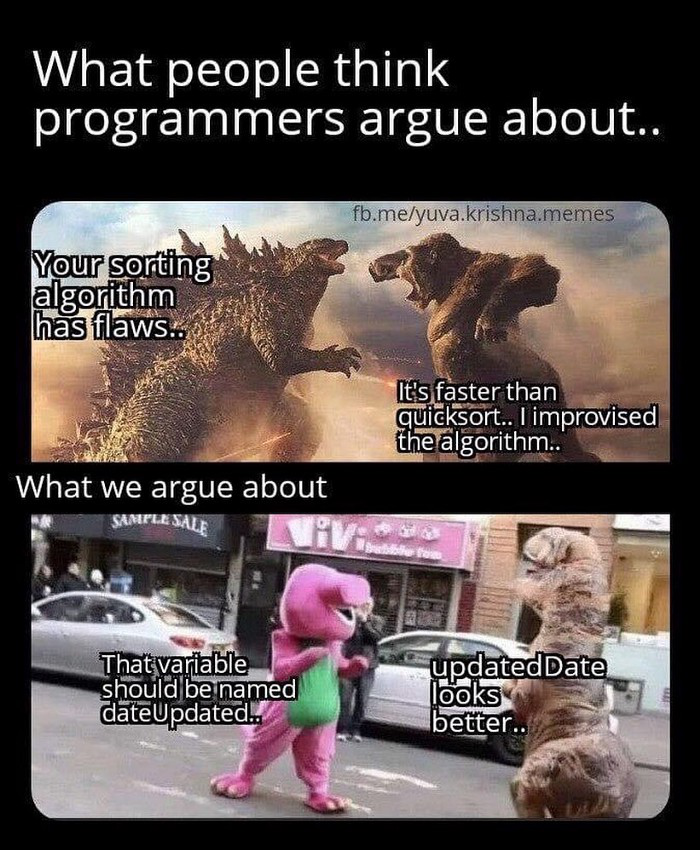

In [7]:
#hide_input
from fastai.vision.all import *
meme = Image.open("./meme_20210430.jpg")
meme

{{ "Not that I think anyone is actually trying to copy my code and run it. This is purely a hypothetical." | fndetail: 1}}

{{ "At the suggestion of Psi. Thanks, Psi!" | fndetail: 2}}

{{ "If I were doing this for a living or something serious, I probably would have fed the entire training set into `GridSearchCV`, rather than just the training portion of split, since `GridSearchCV` does cross-validation." | fndetail: 3}}